In [1]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [14]:
# Load the trained model
model = load_model("C:\\Users\\skovv\\OneDrive\\Visual Studio Code Projects\\Projects\\ISEF_Pharyngitis\\savedModels\\customCNNmodel_v2withCycleGAN.hdf5") #

In [ ]:
def grad_cam_plus_plus(model, img_array, layer_name, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)  # Compute gradients
    grads = tf.maximum(grads, 0)  # ReLU
    grads = grads / (tf.math.reduce_max(grads) + tf.keras.backend.epsilon())  # Normalize

    # Compute weights for Grad-CAM++
    weights = tf.reduce_sum(grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(weights * conv_outputs[0], axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(cam, 0)  # ReLU
    heatmap = heatmap / np.max(heatmap)
    return heatmap

In [ ]:
def preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

In [5]:
# better implementation of the grad_cam_plus_plus function
def enhanced_display_grad_cam(heatmap, image_path, alpha=0.6):
    img = cv2.imread(image_path)
    heatmap = np.maximum(heatmap, 0)  # ReLU activation for heatmap
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)  # Normalize
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)

    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    #plt.show()

    return superimposed_img


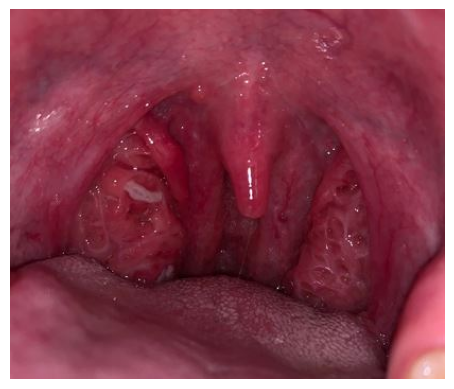

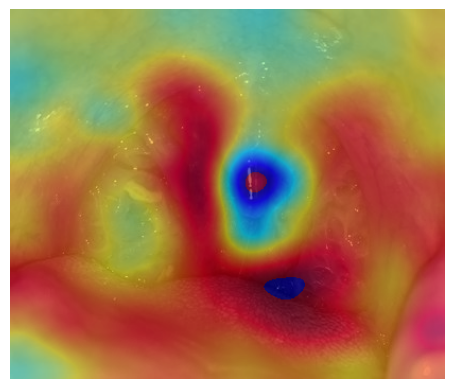

In [15]:
# Example usage:
image_path = "D:\\ML Datasets\\ISEF_24-25_Pharyngitis\\Mendeley&Kaggle Pharyngitis Dataset\\pharyngitis v2\\b14.JPG" #"D:\ML Datasets\ISEF_24-25_Pharyngitis\GradCamTestImgs\Pharyngitis\pharyngitis_image (93).JPG"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()
preprocessed_img = preprocess_image(image_path, (64, 64))
heatmap = grad_cam_plus_plus(model, preprocessed_img, "conv2d_15", class_index=0)  # Use "conv2d_36" for Grad-CAM++ --> reference model.summary for input model
plt.imshow(enhanced_display_grad_cam(heatmap, image_path))